In [ ]:
!pip install simpy


## Non random

In [ ]:
def customer(env, name: str = ''):
  print(f'{name}: Arrives at {env.now}')
  yield env.timeout(30)
  print(f'{name}: Details entered at time {env.now}')
  yield env.timeout(60)
  print(f'{name}: Cash retrieved at time {env.now}')

In [ ]:
import simpy

env = simpy.Environment()
env.process(customer(env))
env.run()

: Arrives at 0
: Details entered at time 30
: Cash retrieved at time 90


In [ ]:
def customer_gen(env, ciat):
  id = 1
  while True:
    yield env.timeout(ciat)
    env.process(customer(env=env, name=f'customer {id}'))
    id += 1

In [ ]:
CUST_INTER_ARR_TIME = 2 * 60 # 2mins

env.process(customer_gen(env=env, ciat=CUST_INTER_ARR_TIME))
env.run(until=10*60) # 10mins

customer 1: Arrives at 210
customer 1: Details entered at time 240
customer 1: Cash retrieved at time 300
customer 2: Arrives at 330
customer 2: Details entered at time 360
customer 2: Cash retrieved at time 420
customer 3: Arrives at 450
customer 3: Details entered at time 480
customer 3: Cash retrieved at time 540
customer 4: Arrives at 570


# Random time

In [ ]:
import simpy, random

def customer(env, name: str = ''):
  print(f'{name}: Arrives at {env.now:.2f}')
  yield env.timeout(30)
  print(f'{name}: Details entered at time {env.now:.2f}')
  yield env.timeout(60)
  print(f'{name}: Cash retrieved at time {env.now:.2f}')

def customer_gen(env):
  id = 1
  while True:
    rand_int_time = random.uniform(1, 3) * 60
    yield env.timeout(rand_int_time)
    env.process(customer(env=env, name=f'customer {id}'))
    id += 1

random.seed(42)

env = simpy.Environment()
env.process(customer_gen(env=env))
env.run(until=10*60) # 10mins

customer 1: Arrives at 136.73
customer 1: Details entered at time 166.73
customer 2: Arrives at 199.73
customer 1: Cash retrieved at time 226.73
customer 2: Details entered at time 229.73
customer 2: Cash retrieved at time 289.73
customer 3: Arrives at 292.74
customer 3: Details entered at time 322.74
customer 4: Arrives at 379.52
customer 3: Cash retrieved at time 382.74
customer 4: Details entered at time 409.52
customer 4: Cash retrieved at time 469.52
customer 5: Arrives at 527.90
customer 5: Details entered at time 557.90


# Finite resources

In [ ]:
import simpy, random

def customer(env, name, atm):
  print(f'{name}: Arrives at {env.now:.2f}')
  with atm.request() as atm_req:
    yield atm_req
    print(f'{name}: gets ATM machine at {env.now:.2f}')
    yield env.timeout(30)
    print(f'{name}: Details entered at time {env.now:.2f}')
    yield env.timeout(60)
    print(f'{name}: Cash retrieved at time {env.now:.2f}')

def customer_gen(env, atm):
  id = 1
  while True:
    rand_int_time = random.uniform(1, 3) * 60
    yield env.timeout(rand_int_time)
    env.process(customer(env=env, name=f'customer {id}', atm=atm))
    id += 1

random.seed(2)

env = simpy.Environment()
atm = simpy.Resource(env, capacity=1)
env.process(customer_gen(env=env, atm=atm))
env.run(until=10*60) # 10mins

customer 1: Arrives at 174.72
customer 1: gets ATM machine at 174.72
customer 1: Details entered at time 204.72
customer 1: Cash retrieved at time 264.72
customer 2: Arrives at 348.46
customer 2: gets ATM machine at 348.46
customer 2: Details entered at time 378.46
customer 3: Arrives at 415.25
customer 2: Cash retrieved at time 438.46
customer 3: gets ATM machine at 438.46
customer 3: Details entered at time 468.46
customer 4: Arrives at 485.43
customer 3: Cash retrieved at time 528.46
customer 4: gets ATM machine at 528.46
customer 4: Details entered at time 558.46


# Data analysis

In [ ]:
import simpy, random, numpy as np

SIM_TIME = 24 * 60 ** 2
WARMUP_TIME = 1 * 60 ** 2

ct_simulation = [] # cycle time
ct_replication = []
waiting_time_simulation = []
waiting_time_replication = []
throughput_simulation = []

def customer(env, name, atm):
  # print(f'{name}: Arrives at {env.now:.2f}')
  customer_enter_time = env.now
  with atm.request() as atm_req:
    yield atm_req
    customer_got_atm = env.now
    # print(f'{name}: gets ATM machine at {env.now:.2f}')
    yield env.timeout(30)
    # print(f'{name}: Details entered at time {env.now:.2f}')
    yield env.timeout(60)
    # print(f'{name}: Cash retrieved at time {env.now:.2f}')
  if env.now > WARMUP_TIME:
    waiting_time_replication.append(customer_got_atm - customer_enter_time)
    ct_replication.append(env.now - customer_enter_time)

def customer_gen(env, atm):
  id = 1
  while True:
    rand_int_time = random.uniform(0, 1) * 60
    yield env.timeout(rand_int_time)
    env.process(customer(env=env, name=f'customer {id}', atm=atm))
    id += 1

for r in range(50):
  random.seed(r)

  env = simpy.Environment()
  atm = simpy.Resource(env, capacity=1)
  env.process(customer_gen(env=env, atm=atm))
  env.run(until=SIM_TIME) #

  ct_simulation.append(np.mean(ct_replication))
  waiting_time_simulation.append(np.mean(waiting_time_replication))
  num_customers = len(ct_replication)
  throughput_simulation.append(num_customers / (SIM_TIME - WARMUP_TIME))

  ct_replication = []
  waiting_time_replication = []

print(f'Average cycle time: {np.mean(ct_simulation)/60 :.2f} +/- {np.std(ct_simulation)/60 :.2f} minutes')
print(f'Average waiting time: {np.mean(waiting_time_simulation)/60 :.2f} +/- {np.std(waiting_time_simulation)/60 :.2f} minutes')
print(f'Average throughput: {np.mean(throughput_simulation)*60**2 :.2f} +/- {np.std(throughput_simulation)*60**2 :.2f} customers/hour')

Average cycle time: 500.53 +/- 5.77 minutes
Average waiting time: 499.03 +/- 5.77 minutes
Average throughput: 40.00 +/- 0.00 customers/hour


# How many ATMS to install

In [ ]:
import simpy, random, numpy as np

SIM_TIME = 24 * 60 ** 2
WARMUP_TIME = 1 * 60 ** 2

ct_simulation = [] # cycle time
ct_replication = []
waiting_time_simulation = []
waiting_time_replication = []
throughput_simulation = []

num_atms = [i for i in range(1, 6)]
ct_atms = []
throughput_atms = []

def customer(env, name, atm):
  # print(f'{name}: Arrives at {env.now:.2f}')
  customer_enter_time = env.now
  with atm.request() as atm_req:
    yield atm_req
    customer_got_atm = env.now
    # print(f'{name}: gets ATM machine at {env.now:.2f}')
    yield env.timeout(30)
    # print(f'{name}: Details entered at time {env.now:.2f}')
    yield env.timeout(60)
    # print(f'{name}: Cash retrieved at time {env.now:.2f}')
  if env.now > WARMUP_TIME:
    waiting_time_replication.append(customer_got_atm - customer_enter_time)
    ct_replication.append(env.now - customer_enter_time)

def customer_gen(env, atm):
  id = 1
  while True:
    rand_int_time = random.uniform(0, 1) * 60
    yield env.timeout(rand_int_time)
    env.process(customer(env=env, name=f'customer {id}', atm=atm))
    id += 1

for atm_cap in num_atms:
  for r in range(50):
    random.seed(r)

    env = simpy.Environment()
    atm = simpy.Resource(env, capacity=atm_cap)
    env.process(customer_gen(env=env, atm=atm))
    env.run(until=SIM_TIME)

    ct_simulation.append(np.mean(ct_replication))
    waiting_time_simulation.append(np.mean(waiting_time_replication))
    num_customers = len(ct_replication)
    throughput_simulation.append(num_customers / (SIM_TIME - WARMUP_TIME))

    ct_replication = []
    waiting_time_replication = []

  ct_atms.append(np.mean(ct_simulation)/60)
  throughput_atms.append(np.mean(throughput_simulation)*60**2)

  ct_simulation = []
  throughput_simulation = []

plots

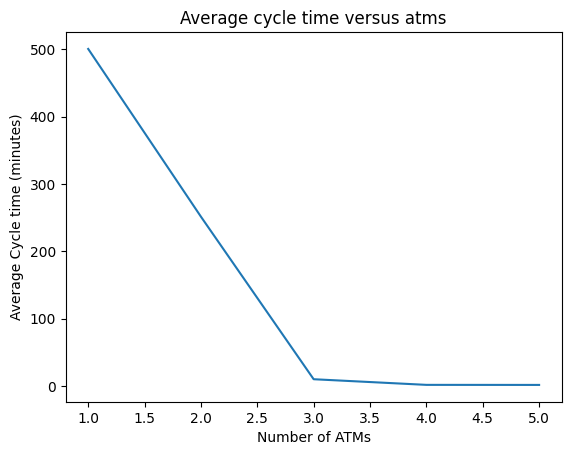

In [ ]:
import matplotlib.pyplot as plt

plt.plot(num_atms, ct_atms)
plt.title('Average cycle time versus atms')
plt.ylabel('Average Cycle time (minutes)')
plt.xlabel('Number of ATMs')
plt.show()

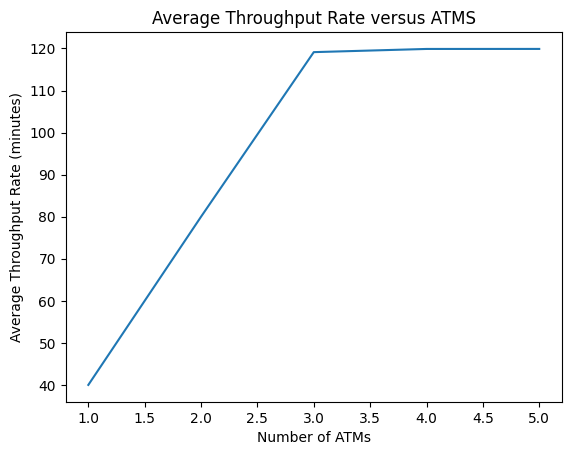

In [ ]:
import matplotlib.pyplot as plt

plt.plot(num_atms, throughput_atms)
plt.title('Average Throughput Rate versus ATMS')
plt.ylabel('Average Throughput Rate (minutes)')
plt.xlabel('Number of ATMs')
plt.show()